# OCR for Reading Expiry Date and Production Code (Recognizing Single Character)

Name: Anthony Kevin Oktavius

In [44]:
import numpy as np
import zipfile
import gc
import cv2
import math
import warnings
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import PIL
import imutils

from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python.client import device_lib
from zipfile import ZipFile
from IPython import display
from google.colab.patches import cv2_imshow
from imutils.contours import sort_contours

print("Device Specifications:")
print(device_lib.list_local_devices())

Device Specifications:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13062723107464186079
xla_global_id: -1
]


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9605417533456758626
 xla_global_id: -1]

## Data Preparation

Download Dotted Fonts Dataset

In [4]:
! wget https://github.com/ameera3/OCR_Expiration_Date/archive/refs/heads/master.zip -O OCR_Expiration_Date.zip
! unzip -qq OCR_Expiration_Date.zip

--2023-11-07 07:03:56--  https://github.com/ameera3/OCR_Expiration_Date/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ameera3/OCR_Expiration_Date/zip/refs/heads/master [following]
--2023-11-07 07:03:56--  https://codeload.github.com/ameera3/OCR_Expiration_Date/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘OCR_Expiration_Date.zip’

OCR_Expiration_Date     [              <=>   ] 242.19M  22.0MB/s    in 18s     

2023-11-07 07:04:14 (13.4 MB/s) - ‘OCR_Expiration_Date.zip’ saved [253956380]



## Data Loading

Data Preprocessing Functions.

In [99]:
def loader(path):
    image_tiff = cv2.imread(path)
    image = cv2.cvtColor(image_tiff, cv2.COLOR_BGR2RGB)
    return transforms.ToTensor()(image)

train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomAffine(
      degrees = 10,
      translate = (0.1, 0.1),
      scale = [0.9, 1.1],
    ),
])

test_transform = transforms.Compose([
])

dot_matrix_image_folder = torchvision.datasets.ImageFolder(
  "/content/OCR_Expiration_Date-master/Custom_Dot_Matrix_Dataset/Dot_Matrix_Test_1",
  loader = loader,
)

print(dot_matrix_image_folder.classes)
print(dot_matrix_image_folder)

NUM_CLASSES = len(dot_matrix_image_folder.classes)
print(f"Number of classes: {NUM_CLASSES}")

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'Colon', 'D', 'Dash', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Period', 'Q', 'R', 'S', 'Slash', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Dataset ImageFolder
    Number of datapoints: 12708
    Root location: /content/OCR_Expiration_Date-master/Custom_Dot_Matrix_Dataset/Dot_Matrix_Test_1
Number of classes: 40


Divide into train and validation dataset

In [100]:
DATASET_SIZE = len(dot_matrix_image_folder)

print(DATASET_SIZE)

TRAIN_SIZE = int(0.8 * DATASET_SIZE)
VAL_SIZE = int(DATASET_SIZE - TRAIN_SIZE)

train_set, val_set = torch.utils.data.random_split(
    dot_matrix_image_folder,
    [TRAIN_SIZE, VAL_SIZE]
)

print(len(train_set), len(val_set))

12708
10166 2542


In [101]:
class DottedFontsDataset(Dataset):
  def __init__(self, image_folder, image_transform = None):
    super(DottedFontsDataset, self).__init__()
    self.image_folder = image_folder
    self.image_transform = image_transform

  def __getitem__(self, item_index):
    image, label = self.image_folder[item_index]

    if self.image_transform is not None:
      image = self.image_transform(image)

    return (image, label)

  def __len__(self):
    return len(self.image_folder)

train_dotted_fonts_dataset = DottedFontsDataset(
  image_folder = train_set,
  image_transform = train_transform,
)

val_dotted_fonts_dataset = DottedFontsDataset(
  image_folder = val_set,
  image_transform = test_transform,
)

print(train_dotted_fonts_dataset[0][0].shape)
print(train_dotted_fonts_dataset[1][0].shape)

torch.Size([1, 65, 65])
torch.Size([1, 65, 65])


In [102]:
BATCH_SIZE = 16

train_dotted_fonts_data_loader = torch.utils.data.DataLoader(
    train_dotted_fonts_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
)

val_dotted_fonts_data_loader = torch.utils.data.DataLoader(
    val_dotted_fonts_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
)

Visualize the dataset

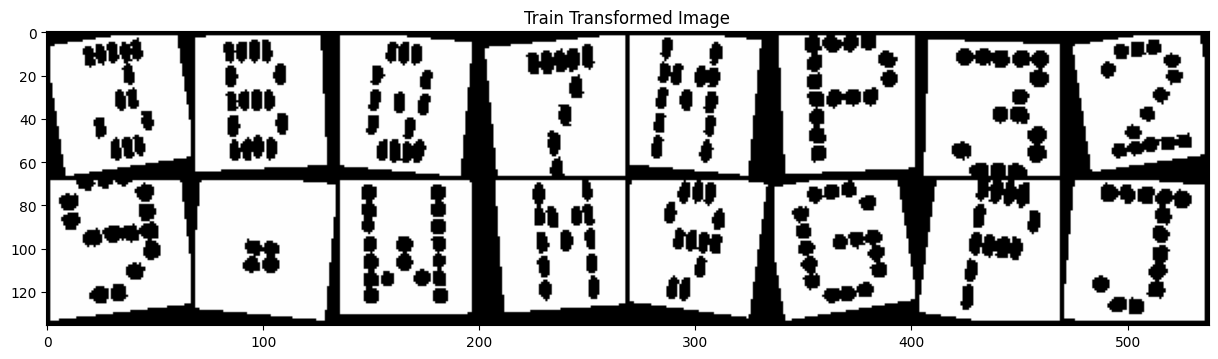

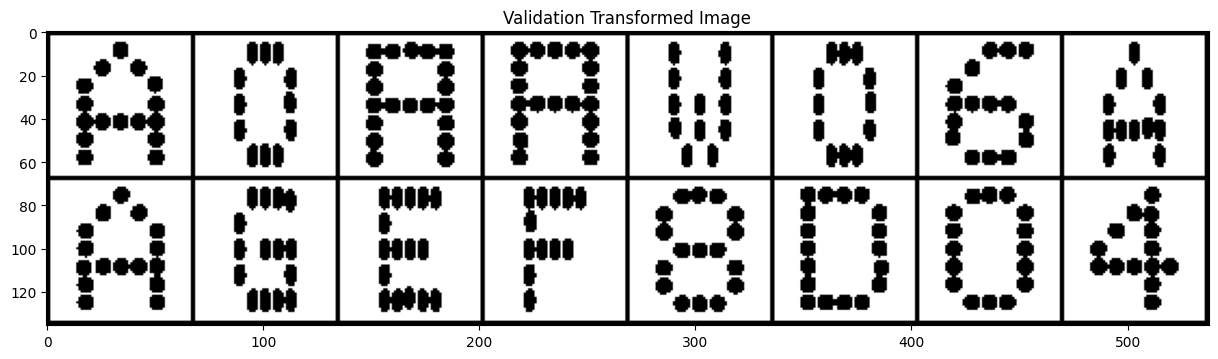

In [105]:
def plot_images_in_grid(title, images, labels, figsize = (15, 15), MIN_INDEX_PLOT = 0, MAX_INDEX_PLOT = 20):
  plt.figure(figsize = figsize)
  plt.suptitle(title)
  for index in range(MIN_INDEX_PLOT, MAX_INDEX_PLOT):
    plt.subplot(5, 5, index + 1)
    plt.axis('off')
    plt.text(x = 10, y = 0.5, s = labels[index], fontsize = 10, bbox = dict(facecolor = 'white'))
    plt.imshow(images[index], cmap = 'gray')

def visualize_pytorch_grid(images_in_batch, title):
  plt.figure(figsize = (15, 15))
  grid_images_in_batch = torchvision.utils.make_grid(images_in_batch)
  plt_compatible_grid_images_in_batch = np.transpose(grid_images_in_batch.numpy(), (1, 2, 0))
  plt.title(title)
  plt.imshow(plt_compatible_grid_images_in_batch)

def visualize_dataloader(data_loader, title):
  iter_loader = iter(data_loader)
  sample_image_batch, _ = next(iter_loader)
  visualize_pytorch_grid(sample_image_batch, title)

visualize_dataloader(train_dotted_fonts_data_loader, "Train Transformed Image")
visualize_dataloader(val_dotted_fonts_data_loader, "Validation Transformed Image")

## Data Modelling